# Compare SUMup observations with SNOWPACK and CFM output

#### Author: Megan Thompson-Munson
#### Date created: 23 September 2021

## User input

In [30]:
icesheet = 'AIS'

In [31]:
# Import libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.io.shapereader as shpreader
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
from scipy.interpolate import griddata
import warnings
warnings.simplefilter("ignore", UserWarning)

# Set up plotting aesthetics, including getting font
font_dir = ['/projects/metm9666/IDS/']
font_files = font_manager.findSystemFonts(fontpaths=font_dir)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.default'] = 'regular'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## 1. Read in data from pickle files

In [32]:
# Raw data dictionaries
data = pickle.load(open(icesheet+'_data.p','rb'))

# Interpoalted data dictionaries
dataInt = pickle.load(open(icesheet+'_data_interpolated.p','rb'))

## 2. Analyze and plot firn variables

### 2.1. Statistical functions

In [33]:
# Function for calculating mean absolute percentage error (MAPE)
def MAPE(observation,measurement):
    n = len(observation)
    diff = np.abs((observation-measurement)/observation)
    mape = (1/n)*np.sum(diff)
    return mape

### 2.2. Density profiles

#### 2.2.1. Uninterpolated

In [34]:
N = np.random.choice(len(data),2)

fig, ax = plt.subplots(1, len(N), figsize=(len(N)*3.6,6))
fig.patch.set_facecolor('#FFFFFF')

for i in range(len(N)):
    
    d = N[i]
    
    # Datasets
    SU = data[d]['SUMup']
    SP = data[d]['SNOWPACK']
    CFM = data[d]['CFM']
    
    # Data arrays
    SU_density = SU['Density']
    SU_depth = SU['Midpoint']
    SP_density = SP['Density']
    SP_depth = SP['Depth']
    CFM_density = CFM['Density']
    CFM_depth = CFM['Depth']
    
    # Label information
    # SUMup
    SU_lat = SU['Latitude']
    SU_lon = SU['Longitude']
    SU_elev = SU['Elevation']
    SU_ID = SU['CoreID']
    SU_date = str(SU['Timestamp'])[:10]

    # SNOWPACK
    SP_lat = SP['Latitude']
    SP_lon = SP['Longitude']
    SP_elev = SP['Elevation']
    SP_VIR = int(SP['VIR'])
    SP_date = str(SP['Timestamp'])[:10]

    # CFM
    CFM_lat = CFM['Latitude']
    CFM_lon = CFM['Longitude']
    CFM_elev = SP['Elevation']
    CFM_date = str(CFM['Timestamp'])[0:11]
    
    ax[i].invert_yaxis()
    ax[i].set_ylabel('Depth (m)')
    ax[i].set_xlabel(r'Density (kg m$^{-3}$)')
    
    ax[i].plot(SU_density,SU_depth,
                  c='#003f5c',markersize=3,marker='o',
                  label='SUMup ({})\n{:.2f}, {:.2f}; {:.0f} m'.format(SU_date,SU_lat,SU_lon,SU_elev))
    ax[i].plot(SP_density[SP_depth<=max(SU_depth)],SP_depth[SP_depth<=max(SU_depth)],
                  c='#ff6e54',markersize=3,marker='o',
                  label='SNOWPACK ({})\n{:.2f}, {:.2f}; {:.0f} m '.format(SP_date,SP_lat,SP_lon,SP_elev))
    ax[i].plot(CFM_density[CFM_depth<=max(SU_depth)],CFM_depth[CFM_depth<=max(SU_depth)],
                  c='#ffa600',markersize=3,marker='o',
                  label='CFM ({})\n{:.2f}, {:.2f}; {:.0f} m '.format(CFM_date,CFM_lat,CFM_lon,CFM_elev))
    
    legend = ax[i].legend(prop={'size':8}, bbox_to_anchor=(-0.0075,1.015), loc='lower left',borderpad=0.1,labelspacing=1.0)
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_boxstyle('Square')


    # Add inset map
    if icesheet=='GrIS':
        ax_map = inset_axes(ax[i], width=1, height=0.975, bbox_to_anchor=(1.065,1.02),bbox_transform=ax[i].transAxes, 
                            loc='lower right', borderpad=0,
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=ccrs.NorthPolarStereo(central_longitude=-45)))
        ax_map.set_extent([-60, -28, 58, 85], ccrs.PlateCarree())
        
    # Add inset map
    if icesheet=='AIS':
        ax_map = inset_axes(ax[i], width=0.85, height=0.85, bbox_to_anchor=(1,1.02),bbox_transform=ax[i].transAxes, 
                            loc='lower right', borderpad=0,
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo()))
        ax_map.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())


    ax_map.axes.xaxis.set_ticks([])
    ax_map.axes.yaxis.set_ticks([])
    ax_map.coastlines(resolution='110m',color='#808080',zorder=0)
    ax_map.scatter(SP_lon,SP_lat,transform=ccrs.PlateCarree(),
                   color='k',s=40,edgecolors='none',marker='*')
    
plt.tight_layout()
# plt.savefig('figures/density-profiles_'+icesheet+'.png',dpi=500)

#### 2.2.2. Interpolated

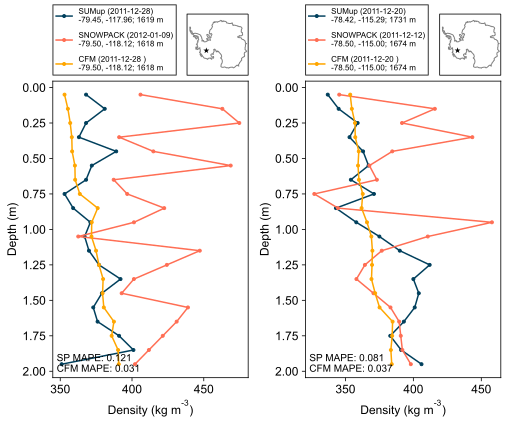

In [35]:
N = np.random.choice(len(data),2)

fig, ax = plt.subplots(1, len(N), figsize=(len(N)*3.6,6))
fig.patch.set_facecolor('#FFFFFF')

for i in range(len(N)):
    
    d = N[i]
    
    # Datasets
    SU = dataInt[d]['SUMup']
    SP = dataInt[d]['SNOWPACK']
    CFM = dataInt[d]['CFM']
    
    # Data arrays
    SU_density = SU['Density']
    SU_depth = SU['Depth']
    SP_density = SP['Density']
    SP_depth = SP['Depth']
    CFM_density = CFM['Density']
    CFM_depth = CFM['Depth']
    
    # Label information
    # SUMup
    SU_lat = SU['Latitude']
    SU_lon = SU['Longitude']
    SU_elev = SU['Elevation']
    SU_ID = SU['CoreID']
    SU_date = str(SU['Timestamp'])[:10]

    # SNOWPACK
    SP_lat = SP['Latitude']
    SP_lon = SP['Longitude']
    SP_elev = SP['Elevation']
    SP_VIR = int(SP['VIR'])
    SP_date = str(SP['Timestamp'])[:10]

    # CFM
    CFM_lat = CFM['Latitude']
    CFM_lon = CFM['Longitude']
    CFM_elev = SP['Elevation']
    CFM_date = str(CFM['Timestamp'])[0:11]
    
    ax[i].invert_yaxis()
    ax[i].set_ylabel('Depth (m)')
    ax[i].set_xlabel(r'Density (kg m$^{-3}$)')
    
    ax[i].plot(SU_density,SU_depth,
                  c='#003f5c',markersize=3,marker='o',
                  label='SUMup ({})\n{:.2f}, {:.2f}; {:.0f} m'.format(SU_date,SU_lat,SU_lon,SU_elev))
    ax[i].plot(SP_density[SP_depth<=max(SU_depth)],SP_depth[SP_depth<=max(SU_depth)],
                  c='#ff6e54',markersize=3,marker='o',
                  label='SNOWPACK ({})\n{:.2f}, {:.2f}; {:.0f} m '.format(SP_date,SP_lat,SP_lon,SP_elev))
    ax[i].plot(CFM_density[CFM_depth<=max(SU_depth)],CFM_depth[CFM_depth<=max(SU_depth)],
                  c='#ffa600',markersize=3,marker='o',
                  label='CFM ({})\n{:.2f}, {:.2f}; {:.0f} m '.format(CFM_date,CFM_lat,CFM_lon,CFM_elev))
    
    legend = ax[i].legend(prop={'size':8}, bbox_to_anchor=(-0.0075,1.015), loc='lower left',borderpad=0.1,labelspacing=1.0)
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_boxstyle('Square')


    # Add inset map
    if icesheet=='GrIS':
        ax_map = inset_axes(ax[i], width=1, height=0.975, bbox_to_anchor=(1.065,1.02),bbox_transform=ax[i].transAxes, 
                            loc='lower right', borderpad=0,
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=ccrs.NorthPolarStereo(central_longitude=-45)))
        ax_map.set_extent([-60, -28, 58, 85], ccrs.PlateCarree())
        
    # Add inset map
    if icesheet=='AIS':
        ax_map = inset_axes(ax[i], width=0.85, height=0.85, bbox_to_anchor=(1,1.02),bbox_transform=ax[i].transAxes, 
                            loc='lower right', borderpad=0,
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo()))
        ax_map.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())


    ax_map.axes.xaxis.set_ticks([])
    ax_map.axes.yaxis.set_ticks([])
    ax_map.coastlines(resolution='110m',color='#808080',zorder=0)
    ax_map.scatter(SP_lon,SP_lat,transform=ccrs.PlateCarree(),
                   color='k',s=40,edgecolors='none',marker='*')
    
    mapeSP = MAPE(SU_density,SP_density)
    mapeCFM = MAPE(SU_density,CFM_density)
    ax[i].text(0.02,0.02,'SP MAPE: {:.3f}\nCFM MAPE: {:.3f}'.format(mapeSP,mapeCFM),
               fontsize=10,transform=ax[i].transAxes)
    
plt.tight_layout()
# plt.savefig('figures/density-profiles_'+icesheet+'.png',dpi=500)

### 2.3. Firn air content

In [36]:
# Empty lists for storing calculated FAC
SU_ID = []
SU_FAC = []
SP_FAC = []
CFM_FAC = []

for i in range(len(data)):
    
    # Datasets
    SU = data[i]['SUMup']
    SP = data[i]['SNOWPACK']
    CFM = data[i]['CFM']
    
    # SUMup data arrays
    SU_density = SU['Density']
    SU_midpoint = SU['Midpoint']
    SU_startdepth = SU['StartDepth']
    SU_stopdepth = SU['StopDepth']
    SU_thickness = SU['Thickness']
    
    # SNOWPACK data arrays
    SP_density = SP['Density']
    SP_depth = SP['Depth']
    SP_height = SP['Height']
    SP_air = SP['Air']
    
    # CFM data arrays
    CFM_density = CFM['Density']
    CFM_depth = CFM['Depth']
    CFM_thickness = CFM_depth[1:]-CFM_depth[:-1]
    CFM_thickness = np.insert(CFM_thickness,0,CFM_depth[0])
    
    # Find min and max heights
    SU_dmax = max(SU_midpoint)
    SU_dmin = min(SU_midpoint)
    SP_dmin = min(SP_height)
    SP_dmax = max(SP_height)
    CFM_dmin = min(CFM_depth)
    CFM_dmax = max(CFM_depth)
    
    # Calculate bounds for calculating FAC
    start = max(SU_dmin,SP_dmin)
    stop = min(SU_dmax,SP_dmax)
    SU_condition = (SU_midpoint>=start) & (SU_midpoint<=stop)
    SP_condition = (SP_depth>=start) & (SP_depth<=stop)
    
    # SUMup FAC
    SU_density = np.where(SU_density>917,917,SU_density) # If SUMup density is greater than 917, make it 917 in order to avoid negative FAC
    SU_air = (917-np.array(SU_density))/917 # Calculate fractional air content and FAC
    
    # Only calculate for value arrays
    if len(SU_thickness[SU_condition])>0:
        SU_fac = np.sum(SU_thickness[SU_condition]*SU_air[SU_condition]) * (SU_dmax/np.sum(SU_thickness[SU_condition]))
        SP_thickness = SP_height[1:] - SP_height[:-1]
        SP_thickness = np.insert(SP_thickness,0,SP_height[0])
        SP_fac = np.sum(SP_thickness[SP_condition]*SP_air[SP_condition])
    
    else:
        SU_fac = 0
        SP_fac = 0
    
    SU_FAC.append(SU_fac)
    SP_FAC.append(SP_fac)

In [37]:
SU_FAC

[1.1513224,
 1.1291714,
 1.0385375,
 1.11783,
 1.1249182,
 1.1065772,
 34.135284,
 29.062002,
 19.872852,
 10.11055]

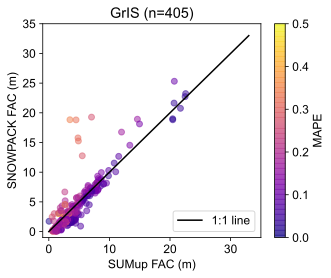

In [8]:
# Prepare array for plotting
suFACtotal = np.array(suFAC)
spFACtotal = np.array(spFAC)

# Filter out zero-FAC
suFACplot = suFACtotal[(suFACtotal>0) & (spFACtotal>0)]
spFACplot = spFACtotal[(suFACtotal>0) & (spFACtotal>0)]
mapeplot = mapetotal[(suFACtotal>0) & (spFACtotal>0)]

# Create figure
fig, ax = plt.subplots(1,figsize=(4.75,4))
fig.patch.set_facecolor('#FFFFFF')

ax.set_xlabel('SUMup FAC (m)')
ax.set_ylabel('SNOWPACK FAC (m)')
ax.set_ylim((-1,35))
ax.set_xlim((-1,35))
ax.set_title(icesheet+' (n={})'.format(len(suFACplot)))

# Plot a 1:1 line
ax.plot([0,33],[0,33],c='k',zorder=1000,label='1:1 line')
ax.legend(loc='lower right')

# Plot FAC shaded by MAPE
fac = ax.scatter(suFACplot,spFACplot,vmin=0,vmax=0.5,alpha=0.5)

plt.tight_layout()
# plt.savefig('figures/fac_'+icesheet+'.png',dpi=500)

### 2.4. Critical densities

## 3. Examine meteorological variables

### 3.1. Calculate and examine meterological variables

In [9]:
dfsSmet = []
dfsSmetMean = []
dfsSmetSum = []

for i in range(len(data)):
    
    merra2 = data[i]['MERRA-2']
    
    # Create dataframe from dictionary (easier for plotting)
    df = pd.DataFrame.from_dict(merra2)
    
    # Calculate time change for snow and rain rates
    df['dt'] = (df.Timestamp-df.Timestamp.shift()).dt.total_seconds()/3600

    # Calculate SMB
    df['SMB'] = ((df.Snow-df.Wind)+df.Rain)*df['dt'] + df.Evaporation + df.Sublimation - df.Runoff
    
    # Get years and months; set index as timestamp
    df['Year'] = df.Timestamp.dt.year
    df['Month'] = df.Timestamp.dt.month
    df.set_index('Timestamp',inplace=True)
    
    # Resample for annual means/sums and full mean
    dfMean = df.resample('y').mean()
    dfMean = dfMean[['ID','Latitude','Longitude','Year','Temperature']]
    dfSum = df.resample('y').sum()
    dfSum['ID'] = dfMean['ID']
    dfSum['Year'] = dfMean['Year']
    dfSum['Latitude'] = dfMean['Latitude']
    dfSum['Longitude'] = dfMean['Longitude']
    dfSum = dfSum[['ID','Latitude','Longitude','Year','SMB']]
    
    # Add all dataframes to lists
    dfsSmet.append(df)
    dfsSmetMean.append(dfMean)
    dfsSmetSum.append(dfSum)

### 3.2. Plot variables

#### 3.2.1. Timeseries

#### 3.2.2. SMB maps

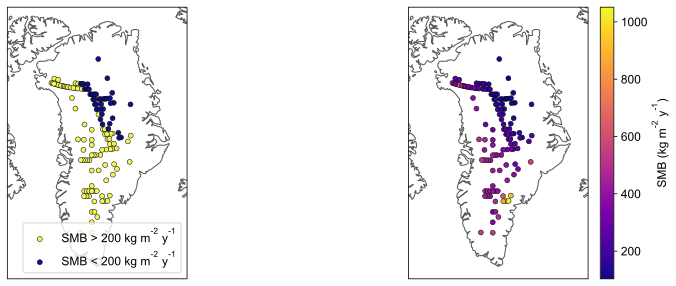

In [10]:
# Set up figure for plotting MERRA-2 locations
fig = plt.figure(figsize=(12,5))
fig.patch.set_facecolor('#FFFFFF')

# Set up plotting parameters
if icesheet == 'AIS':
    ax1 = plt.subplot(1,2,1, projection=ccrs.SouthPolarStereo())
    ax1.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    ax1.coastlines(resolution='50m',color='#555555')
    ax2 = plt.subplot(1,2,2, projection=ccrs.SouthPolarStereo())
    ax2.set_extent([-180, 180, -90, -65], ccrs.PlateCarree())
    ax2.coastlines(resolution='50m',color='#555555')

# Set up plotting parameters
if icesheet == 'GrIS':
    ax1 = plt.subplot(1,2,1, projection=ccrs.NorthPolarStereo(central_longitude=-45))
    ax1.set_extent([-60, -28, 58, 85], ccrs.PlateCarree())
    ax1.coastlines(resolution='50m',color='#555555')
    ax2 = plt.subplot(1,2,2, projection=ccrs.NorthPolarStereo(central_longitude=-45))
    ax2.set_extent([-60, -28, 58, 85], ccrs.PlateCarree())
    ax2.coastlines(resolution='50m',color='#555555')

# Get mean over correct RCI
dfs = []
for i in range(len(dfsSmetSum)):
    
    df = dfsSmetSum[i]
    if icesheet=='GrIS':
        df = df[df.Year<1996]
    else:
        df = df
    dfmean = df.mean()
    dfs.append(dfmean)

dfAnnualMeans = pd.concat(dfs,axis=1).transpose()
dfAnnualMeans = dfAnnualMeans.drop_duplicates()
dfOver200 = dfAnnualMeans[dfAnnualMeans.SMB>200]
dfUnder200 = dfAnnualMeans[dfAnnualMeans.SMB<200]

ax1.scatter(dfOver200.Longitude,dfOver200.Latitude,transform=ccrs.PlateCarree(),
            c='#f2f358ff',s=25,edgecolors='k',lw=0.5,
            label='SMB > 200 kg m$^{-2}$ y$^{-1}$')
ax1.scatter(dfUnder200.Longitude,dfUnder200.Latitude,transform=ccrs.PlateCarree(),
            c='#101084ff',s=25,edgecolors='k',lw=0.5,
            label='SMB < 200 kg m$^{-2}$ y$^{-1}$')

ax1.legend(loc='lower right')

plot2 = ax2.scatter(dfAnnualMeans.Longitude,dfAnnualMeans.Latitude,transform=ccrs.PlateCarree(),
                      c=dfAnnualMeans.SMB,cmap='plasma',s=25,edgecolors='k',lw=0.5,
                      vmin=dfAnnualMeans.SMB.min(),vmax=dfAnnualMeans.SMB.max())
    
cbar = plt.colorbar(plot2,label='SMB (kg m$^{-2}$ y$^{-1}$)',fraction=0.046, pad=0.04)
# plt.savefig('figures/smb_'+icesheet+'.png',dpi=500)

## 4. Evaluate firn properties based on climatology

### 4.1. Plot firn density based on SMB

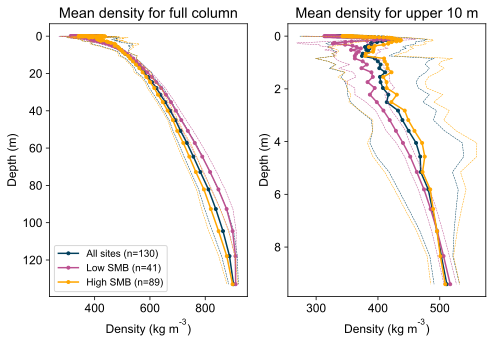

In [11]:
fig, ax = plt.subplots(1,2,figsize=(7,5))
fig.patch.set_facecolor('#FFFFFF')

ax[0].invert_yaxis()
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel(r'Density (kg m$^{-3}$)')
ax[0].set_title('Mean density for full column')

ax[1].invert_yaxis()
ax[1].set_ylabel('Depth (m)')
ax[1].set_xlabel(r'Density (kg m$^{-3}$)')
ax[1].set_title('Mean density for upper 10 m')

IDs = []
spDensities = []
for i in range(len(data)):
    
    sp = data[i]['SNOWPACK']
    
    # Extract ID and analyze only unique IDs
    spID = sp['ID']
    if spID not in IDs:
    
        # Define relevant variables
        spDepth = sp['Depth']
        spDensity = sp['Density']

        # Interpolate modeled density onto common grid
        z = np.logspace(-3, np.log10(150), 100)
        spDensityInt = griddata(spDepth,spDensity,z)
        
        # Append lists
        spDensities.append(spDensityInt)
        IDs.append(spID)

spDensities = np.array(spDensities)

spDensitiesLow = []
spDensitiesHigh = []
for i in range(len(dfAnnualMeans)):
    smb = dfAnnualMeans.iloc[i].SMB
    spDensity = spDensities[i]

    # Append lists based on SMB
    if smb < 200:
        spDensitiesLow.append(spDensity)
    else:
        spDensitiesHigh.append(spDensity)
        
# All sites mean density
spDensitiesMean = np.mean(spDensities,axis=0)
spDensitiesStd = np.std(spDensities,axis=0)
    
ax[0].plot(spDensitiesMean,z,
        c='#003f5c',marker='o',markersize=3,label='All sites (n={})'.format(len(spDensities)))
ax[0].plot(spDensitiesMean+spDensitiesStd,z,
       c='#003f5c',ls='--',lw=0.5)
ax[0].plot(spDensitiesMean-spDensitiesStd,z,
       c='#003f5c',ls='--',lw=0.5)

# Mean density SMB < 200
spDensitiesLowMean = np.mean(spDensitiesLow,axis=0)
spDensitiesLowStd = np.std(spDensitiesLow,axis=0)

ax[0].plot(spDensitiesLowMean,z,
        c='#bc5090',marker='o',markersize=3,label='Low SMB (n={})'.format(len(spDensitiesLow)))
ax[0].plot(spDensitiesLowMean+spDensitiesLowStd,z,
       c='#bc5090',ls='--',lw=0.5)
ax[0].plot(spDensitiesLowMean-spDensitiesLowStd,z,
       c='#bc5090',ls='--',lw=0.5)

# Mean density SMB > 200
spDensitiesHighMean = np.mean(spDensitiesHigh,axis=0)
spDensitiesHighStd = np.std(spDensitiesHigh,axis=0)

ax[0].plot(spDensitiesHighMean,z,
        c='#ffa600',marker='o',markersize=3,label='High SMB (n={})'.format(len(spDensitiesHigh)))
ax[0].plot(spDensitiesHighMean+spDensitiesHighStd,z,
       c='#ffa600',ls='--',lw=0.5)
ax[0].plot(spDensitiesHighMean-spDensitiesHighStd,z,
       c='#ffa600',ls='--',lw=0.5)

# Plot upper layers

ax[1].plot(spDensitiesMean[z<=10],z[z<=10],
        c='#003f5c',marker='o',markersize=3,label='All sites (n={})'.format(len(spDensities)))
ax[1].plot(spDensitiesMean[z<=10]+spDensitiesStd[z<=10],z[z<=10],
       c='#003f5c',ls='--',lw=0.5)
ax[1].plot(spDensitiesMean[z<=10]-spDensitiesStd[z<=10],z[z<=10],
       c='#003f5c',ls='--',lw=0.5)

ax[1].plot(spDensitiesLowMean[z<=10],z[z<=10],
        c='#bc5090',marker='o',markersize=3,label='Low SMB (n={})'.format(len(spDensitiesLow)))
ax[1].plot(spDensitiesLowMean[z<=10]+spDensitiesLowStd[z<=10],z[z<=10],
       c='#bc5090',ls='--',lw=0.5)
ax[1].plot(spDensitiesLowMean[z<=10]-spDensitiesLowStd[z<=10],z[z<=10],
       c='#bc5090',ls='--',lw=0.5)

ax[1].plot(spDensitiesHighMean[z<=10],z[z<=10],
        c='#ffa600',marker='o',markersize=3,label='High SMB (n={})'.format(len(spDensitiesHigh)))
ax[1].plot(spDensitiesHighMean[z<=10]+spDensitiesHighStd[z<=10],z[z<=10],
       c='#ffa600',ls='--',lw=0.5)
ax[1].plot(spDensitiesHighMean[z<=10]-spDensitiesHighStd[z<=10],z[z<=10],
       c='#ffa600',ls='--',lw=0.5)

ax[0].legend(prop={'size':10},loc='lower left')
plt.tight_layout()
# plt.savefig('figures/mean-density_'+icesheet+'.png',dpi=500)